Запуск обучения моделей с параметрами как в конфиге TabDDPM на данных, где на категориальных признаках используется OHE. Этот датасет подается TabDDPM как полностью числовой (число категориальных переменных равно 0). Внутри обучения модели на каждом шаге цикла обучения при получении батча происходит добавление шума $N(0, \sigma)$, где $\sigma$ как раз меняется от модели к модели. У первых нескольких моделей она константная, у остальных моделей есть некое ее изменение (постепенное уменьшение). После обучения модели и сэмплирования происходит перевод закодированных категориальных переменных в изначальные значения. 

In [2]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm_ohe_noise.tabddpm_ohe_noise import *

from tqdm.notebook import tqdm

### Cкачиваем и преобразовываем данные

In [2]:
dataname = 'adult_ON'

In [3]:
# dataname_initial = 'adult'

# with open(f'data/Info/{dataname_initial}.json', 'r') as f:
#     info = json.load(f)

# info['name'] = dataname
# info['data_path'] = f'data/{dataname}/{dataname}.data'
# info['test_path'] = f'data/{dataname}/{dataname}.test'
# info['task_type'] = 'regression'

# with open(f'data/Info/{dataname}.json', 'w', encoding='utf-8') as f:
#     json.dump(info, f, ensure_ascii=False, indent=4)

# download_dataset('adult', dataname)

# import os
# for file in tqdm(os.listdir(f'./data/{dataname}')):
#     old_file = os.path.join(f'./data/{dataname}', file)
#     new_file = os.path.join(f'./data/{dataname}', file.replace(dataname_initial, dataname))
#     os.rename(old_file, new_file)
    
# categorial_to_OHE(dataname)
# process_data(dataname)
# postprocess_OHE(dataname, dataname_initial)

### Подготовка

In [4]:
dataname

'adult_ON'

In [5]:
with open(f'data/Info/{dataname}.json', 'r') as f:
    info = json.load(f)

In [6]:
model_name = 'tabddpm_ON'

CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)

In [7]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('save_path',
                   f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")
CONFIG.add_arg('sample_save_path',
                   f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")

Device: cuda


### Train

In [8]:
CONFIG.add_arg('mode', 'train')
CONFIG.add_arg('num_noise', info['prev_cat_num'])

In [9]:
CONFIG.get_all_args()

{'dataname': 'adult_ON',
 'method': 'tabddpm_ON',
 'device': 'cuda',
 'save_path': 'synthetic/adult_ON/tabddpm_ON.csv',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/adult_ON/tabddpm_ON.csv',
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 103,
 'real_path': './synthetic/adult_ON/initial_real.csv',
 'test_path': './synthetic/adult_ON/initial_test.csv',
 'info_path': './data/adult_ON/initial_info.json'}

In [12]:
model_save_path_hist = []
for sigma in [0, 0.001, 0.01, 0.1, 0.25, 0.5]:
    model_save_path=f"./models/{model_name}/ckpt/{model_name}_const_{str(sigma).replace('.', '_')}"
    model_save_path_hist.append(model_save_path)
    
    tabddpm_noise_ohe = TabDDPM_OHE_Noise(CONFIG, model_save_path=model_save_path, sigmas=np.ones(100000) * sigma)
    tabddpm_noise_ohe.train()

    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    start_step = 0
    for l in loss.columns[1:]:
      plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    plt.ylim([loss['gloss'][start_step:].min()-0.1, 
              np.min([2, loss['gloss'][start_step:].max() + 0.1])])  
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    
    plt.show()
    
    for file in tqdm(os.listdir(model_save_path)):
        if ('0000' in file) or ('model_ema.pt' in file):
            os.remove(os.path.join(model_save_path, file))

In [11]:
sigmas_list = []

# 1/3 х 0.5 + 1/3 х 0.1 + 1/3 х 0.01
len_0_5 = 100000 // 3
len_0_1 = 100000 // 3
len_0_01 = 100000  - len_0_5 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))

# 1/3 х 0.5 + 1/3 х 0.1 + 1/3 х 0.01
len_0_5 = 100000 // 3
len_0_1 = 100000 // 3
len_0_01 = 100000  - len_0_5 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))
# 1/6 x 0.5 + 1/6 x 0.25 + 0.1 x 1/3 + 0.01 x 1/3
len_0_5 = 100000 // 6
len_0_25 = 100000 // 6
len_0_1 = 100000 // 3
len_0_01 = 100000  - len_0_5 -len_0_25 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_25)  * 0.25,
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))

# 1/8 x 0.5 + 1/8 x 0.25 + 0.1 x 1/4 + 0.01 x 1/2
len_0_5 = 100000 // 8
len_0_25 = 100000 // 8
len_0_1 = 100000 // 4
len_0_01 = 100000  - len_0_5 -len_0_25 - len_0_1

sigmas_list.append(np.concatenate([np.ones(len_0_5)  * 0.5, 
                    np.ones(len_0_25)  * 0.25,
                    np.ones(len_0_1)  * 0.1,
                    np.ones(len_0_01)  * 0.01
                   ]))

# linear from 0.5 to 0.01
sigmas_list.append(np.linspace(0.5, 0.01, 100000))

# linear from 0.25 to 0.01
sigmas_list.append(np.linspace(0.25, 0.01, 100000))

# cosine from 0.5 to 0
sigmas_list.append((np.cos(np.linspace(0, np.pi, 100000)) + 1) * 0.5 / 2)

# cosine from 0.25 to 0
sigmas_list.append((np.cos(np.linspace(0, np.pi, 100000)) + 1) * 0.25 / 2)

In [11]:
for i, sigmas in enumerate(sigmas_list):
    model_save_path=f"./models/{model_name}/ckpt/{model_name}_mult_{i}"
    model_save_path_hist.append(model_save_path)
    
    tabddpm_noise_ohe = TabDDPM_OHE_Noise(CONFIG, model_save_path=model_save_path, sigmas=sigmas)
    tabddpm_noise_ohe.train()

    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    start_step = 0
    for l in loss.columns[1:]:
      plt.plot(loss['step'][start_step:], loss[l][start_step:], label=l)
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    plt.ylim([loss['gloss'][start_step:].min()-0.1, 
              np.min([2, loss['gloss'][start_step:].max() + 0.1])])  
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    
    plt.show()

    for file in tqdm(os.listdir(model_save_path)):
        if '0000' in file:
            os.remove(os.path.join(model_save_path, file))

In [4]:
dataname = 'adult_ON'
model_short = 'tabddpm_ON'
model_name = 'tabddpm_ON'

model_save_path_hist = []
for sigma in [0, 0.001, 0.01, 0.1, 0.25, 0.5]:
    model_save_path=f"./models/{model_short}/ckpt/{model_short}_const_{str(sigma).replace('.', '_')}"
    model_save_path_hist.append(model_save_path)

for i, sigmas in enumerate(range(8)):
    model_save_path=f"./models/{model_short}/ckpt/{model_short}_mult_{i}"
    model_save_path_hist.append(model_save_path)

  0%|          | 0/14 [00:00<?, ?it/s]

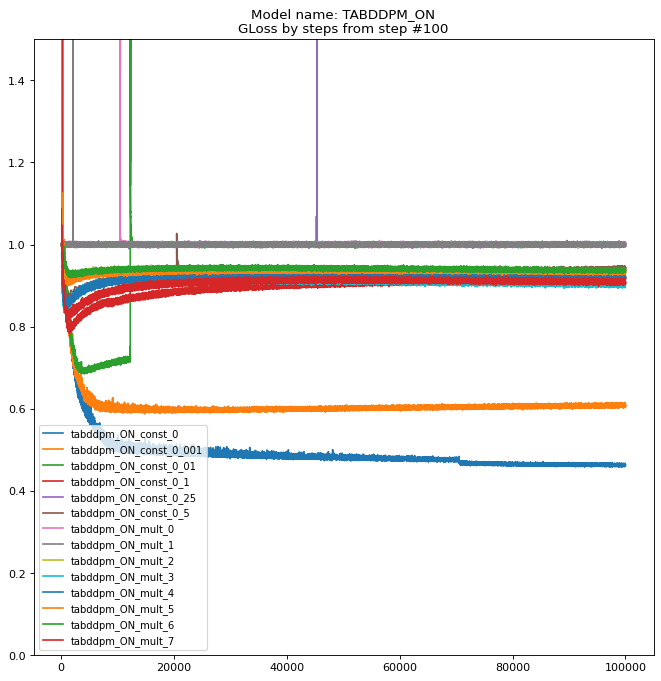

In [9]:
plt.figure(figsize=(10, 10), dpi=80)

for model_save_path in tqdm(model_save_path_hist):
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], label=model_save_path.split('/')[-1])

plt.ylim([0, 1.5])    
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nGLoss by steps from step #{start_step}")

plt.savefig(f'total_loss_image.png')

plt.show()

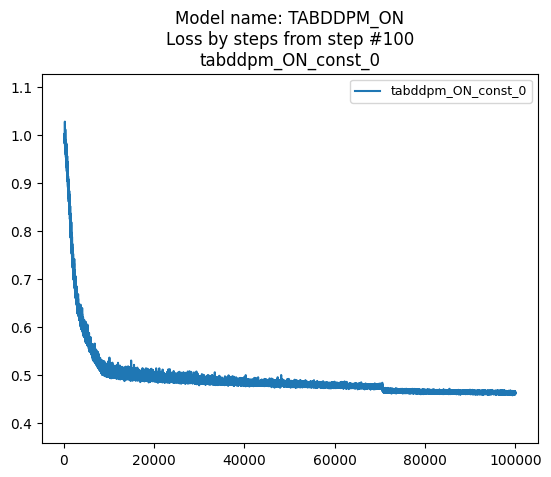

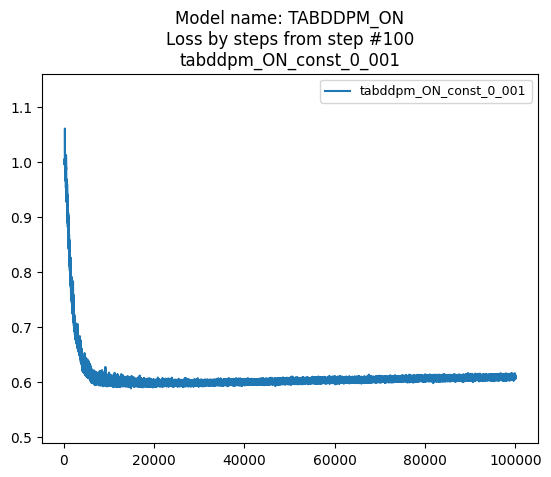

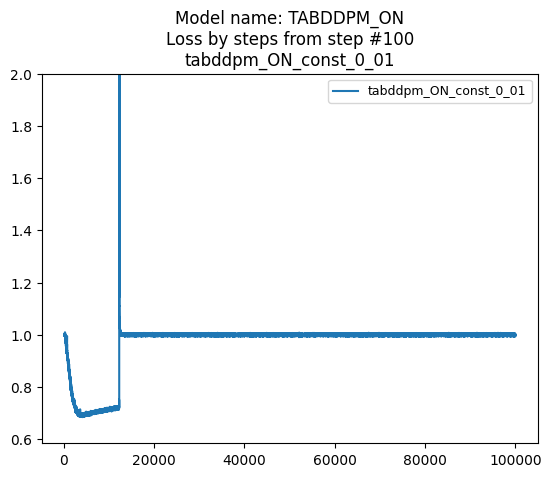

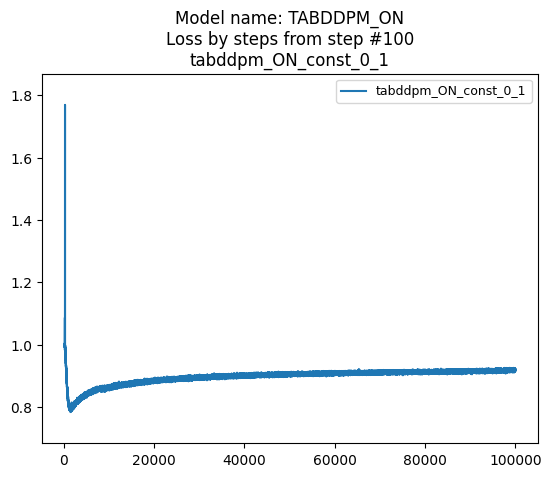

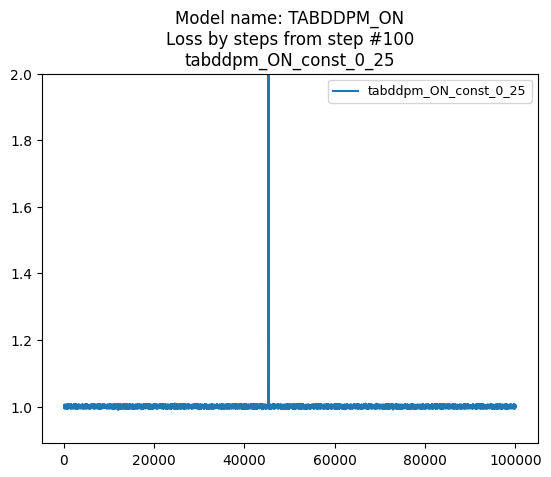

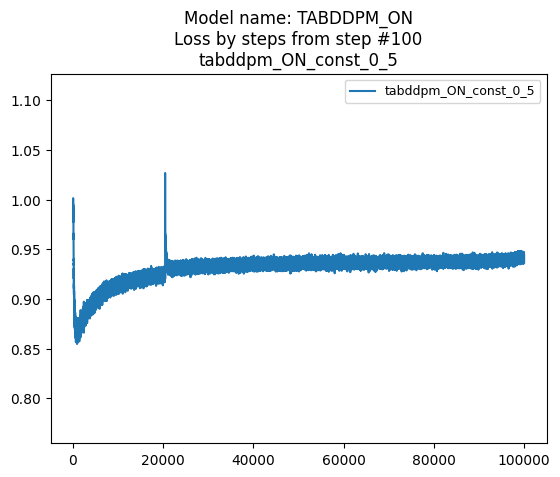

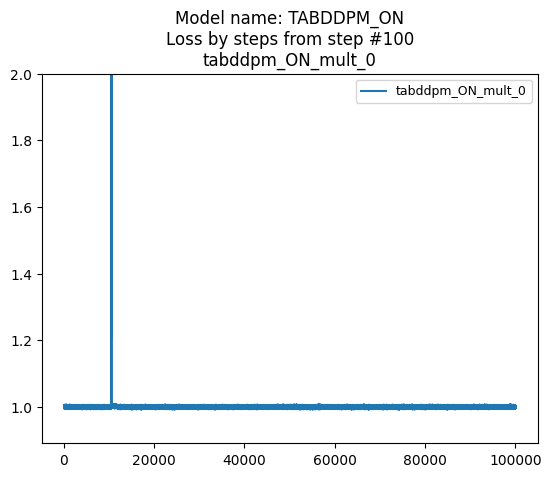

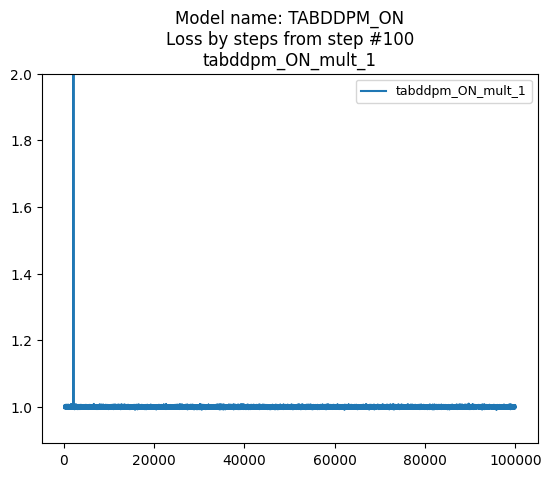

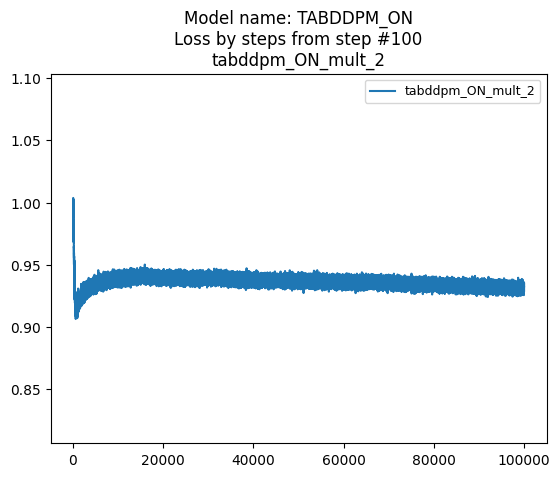

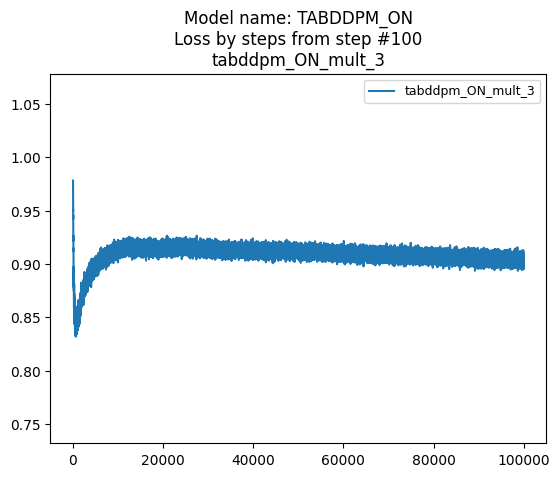

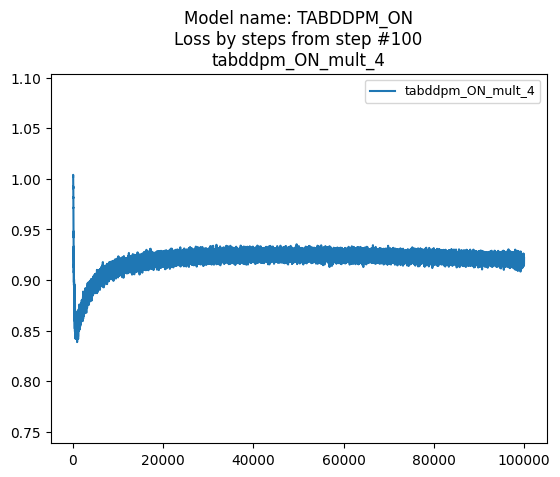

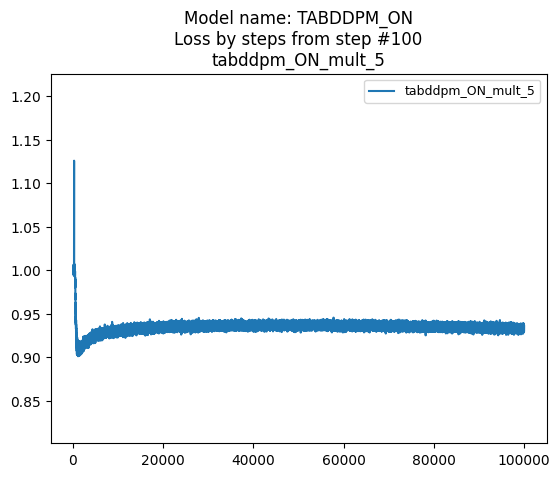

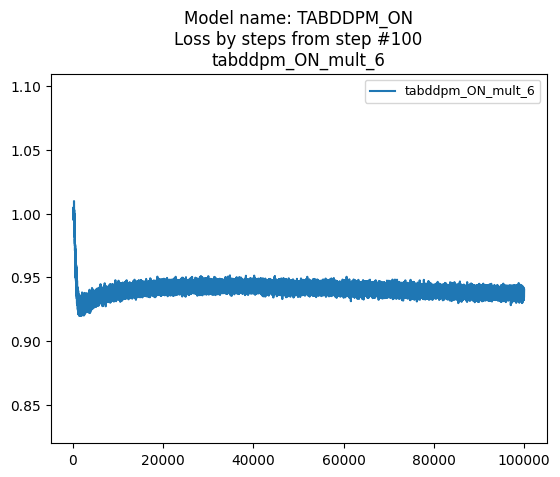

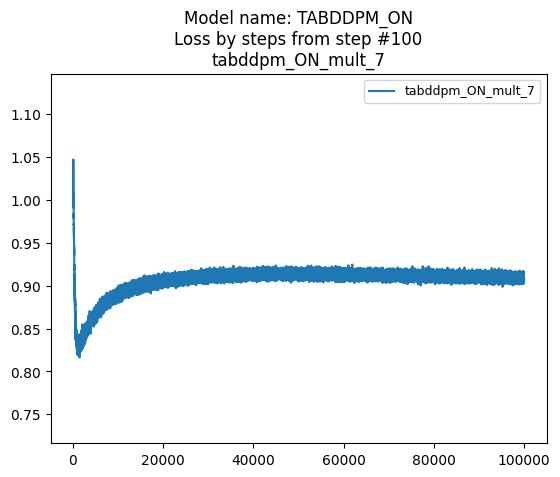

In [10]:
for model_save_path in model_save_path_hist:
    loss = pd.read_csv(f'{model_save_path}/loss.csv')
    
    start_step = 100
    plt.plot(loss['step'][start_step:], loss['gloss'][start_step:], label=model_save_path.split('/')[-1])

    plt.ylim([loss['gloss'][start_step:].min()-0.1, 
              np.min([2, loss['gloss'][start_step:].max() + 0.1])])    
    plt.legend()
    plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}\n{model_save_path.split('/')[-1]}")
    
    plt.savefig(f'{model_save_path}/loss_image.png')
    plt.show()